In [1]:
import pandas as pd
import numpy as np
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import pygad
from time import time

In [2]:
'''
The provided evaluation function with minor modifications to reduce runtime
'''
def func(F,s0,link_flows_real,PRINT, A, B):

    #parameters
    
    t = time()
    
    t_link = np.array([30,3,28,3,15,10,0,0,10,0])
    t_path = np.dot(A.T,t_link)

    alpha = 1

    r = np.array([10])

    G = np.dot((F-np.eye(10)),A)

    #Network Structure
    N = {
        1:[2,4,7],
        2:[3,5],
        3:[4],
        4:[],
        5:[5],
        6:[3],
        7:[8],
        8:[4]
    } ## Node Structure

    link_node = np.array([[1, 1, 4],
            [2, 1, 2],
            [3, 2, 3],
            [4, 3, 4],
            [5, 5, 6],
            [6, 7, 8],
            [7, 2, 3], 
            [8, 6, 3],
            [9, 1, 7],
            [10, 8, 4],]) ## Link and node

    #Origin List
    O = np.array([1])
    D = np.array([4])

    #cost matrix
    c = np.ones((8,8)) * np.inf
    
    # print("Group 0: %.6fs" % (time() - t))
    t = time()
    
    for i in range(8):
        c[i,i] = 0
    for i in range(len(link_node)):
        link_id = link_node[i,0]
        start = link_node[i,1]
        end = link_node[i,2]
        c[start - 1, end - 1] = t_link[link_id-1]
    
    # print("Group 1: %.6fs" % (time() - t))
    t = time()

    od_num = len(r)
    link_num = len(link_node)
    node_num = len(N)
    path_num = A.shape[1]

    ###OBJECTIVE
    def obj(h):
        return sum(np.multiply((np.log(h)-1),h))+np.dot(t_path,h)
    '''
    def obj_der(h):
        der = np.zeros_like(h)
        for i in range(len(h)):
            der[i] = np.log(h[i])+t_path[i]
        return der
    '''
    def obj_der(h):
        return np.log(h) + t_path

    def obj_hess(h):
        hess = np.zeros((len(h),len(h)))
        for i in range(len(h)):
            hess[i,i] = 1/h[i]
        return hess


    ###CONSTRAINTS
    from scipy.optimize import LinearConstraint
    LOWER_cap = -s0
    UPPER_cap = [np.inf]*link_num
    Capacity_constraint = LinearConstraint(G,LOWER_cap,UPPER_cap)

    LOWER_r = np.ones((od_num))*10
    UPPER_r = np.ones((od_num))*10
    R_constraint = LinearConstraint(B,LOWER_r,UPPER_r)

    LOWER_nn = np.zeros((path_num))
    UPPER_nn = [np.inf]*path_num
    NN_constraint = LinearConstraint(np.eye(path_num),LOWER_nn,UPPER_nn)

    # print("Group 2: %.6fs" % (time() - t))
    t = time()

    ###OPTIMIZE
    for i in range(10):
        h0 = np.ones((path_num))*2.5
        Solution = minimize(obj, h0, method='trust-constr', jac=obj_der, hess=obj_hess,
                   constraints=[Capacity_constraint,R_constraint,NN_constraint],
                   options={'verbose': 0,'disp': False}) 
        # print(i, Solution.x, Solution.message)
        if Solution.status != 0:
            break
    
    # print("Group 3: %.6fs" % (time() - t))
    t = time()

    lm = Solution.v[0]
    h_UE = Solution.x
    capacity = np.dot(np.dot(F,A),h_UE)+s0
    link_flows = np.dot(A,h_UE)
    
    error = np.linalg.norm(link_flows-link_flows_real) # L2 norm of the difference between the real flows and the flows solved from the given F

    if PRINT == 1:
        print ("F: ", np.round(F, 3))
        print ("Path Flow: ",np.round(h_UE,3))
        print ("Capacity: ",np.round(np.dot(np.dot(F,A),h_UE)+s0,3))
        print ("Link flow: ",np.round(np.dot(A,h_UE),3))
        print ("Error:", np.round(error, 3))
        print ("-----------------------------------------------")
        
    # print("Group 4: %.6fs" % (time() - t))
    t = time()

    return link_flows, capacity, error #output steady-state link flows and capacities and the error


In [3]:
### specify the input functions

# set a random F
F = np.zeros((10,10))

#s0
s0 = np.array([np.inf,np.inf,np.inf,np.inf,np.inf,np.inf,5,5,5,np.inf])

#real link flows
link_flows_real = np.array([0.89264769, 4.56191687, 0.01650574, 4.56191687, 4.54541114,
       4.54543543, 4.54541114, 4.54541114, 4.54543543, 4.54543543])

A = pd.read_csv('A Matrix.csv', index_col=0).values
B = pd.read_csv('B Matrix.csv', index_col=0).values

In [4]:
F_real = pd.read_csv('F Matrix.csv', index_col=0).values
F_real

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. , -0.1,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

We need to limit certain values in the matrix to 0, leaving the remaining to be genes in the population. In this case we have an $F$ matrix beforehand and we know where the values are. For other examples, we can modify these parameters according to where the 0 values need to be.

In [121]:
# Get indices of non-zero values
rows, cols = np.where(F_real != 0)
for i in range(len(list(rows))):
    print(f"Row = {rows[i]}, col = {cols[i]}, value = {F_real[rows[i]][cols[i]]}")

Row = 6, col = 4, value = -0.1
Row = 7, col = 4, value = -0.1
Row = 8, col = 5, value = -0.1


In [5]:
link_flows, capacity, error = func(F,#the given F
                                   s0,#the given s0
                                   link_flows_real, # real link flows
                                   0, #print results (1) or not (0)
                                   A, B)
error

1.5538524446395765

In [6]:
link_flows, capacity, error = func(F_real, s0, link_flows_real, 0, A, B)
error

1.1227738477047337e-08

## Defining an alternative score for differences between real flows and computed flows

TS-SS computes the similarity between two vectors from diverse perspective and generates the similarity value from two vectors not only from the angle and Euclidean distance between them, but also the difference between their magnitudes.

https://www.computer.org/csdl/proceedings-article/bigdataservice/2016/2251a142/12OmNweBUID

Test runs with the same hyperparameters show that using TS-SS similarity yields slightly better results than using L2 norm.

In [140]:
def cosine(v0, v1):
    dot_product = np.dot(v0, v1.T)
    denominator = (np.linalg.norm(v0) * np.linalg.norm(v1))
    return dot_product/denominator
    
def euclidean(v0, v1):
    return np.linalg.norm(v0 - v1)

def theta(v0, v1):
    return np.arccos(cosine(v0, v1)) + np.radians(10)

def triangle(v0, v1):
    t = np.radians(theta(v0, v1))
    return ((np.linalg.norm(v0) * np.linalg.norm(v1)) * np.sin(t))/2

def magnitude_diff(v0, v1):
    return abs((np.linalg.norm(v0) - np.linalg.norm(v1)))

def sector(v0, v1):
    ED = euclidean(v0, v1)
    MD = magnitude_diff(v0, v1)
    t = theta(v0, v1)
    return math.pi * (ED + MD)**2 * t/360

def ts_ss(v0, v1):
    v0[np.isinf(v0)] = 0
    v1[np.isinf(v1)] = 0
    score = triangle(v0, v1) * sector(v0, v1)
    return score

In [8]:
# Try the TS-SS similarity function
tmp_v0 = np.random.rand(10)
tmp_v1 = np.random.rand(10)
print(ts_ss(tmp_v0, tmp_v1))
print(ts_ss(tmp_v0, tmp_v0)) # Identical vectors
print(ts_ss(tmp_v0, -5*tmp_v0)) # Vectors of different directions & very different magnitudes

0.00021356543318654052
0.0
6.827896906936562


$$\text{fitness score} = \frac{1}{2^{\text{similarity score}}}\\
\text{similarity score = 0 (identical vectors)} \iff \text{fitness score} = 1$$

In [189]:
'''
The fitness function used in genetic algorithm.
Both scores (L2 norm & TS-SS) are recorded.
For both similarity functions, bigger scores indicate bigger differences -- we need to minimize this.
The fitness function priorities higher fitness values. So we need to invert the similarity scores.
Fitness value = 1 / 2^(similarity)
'''
def fitness_func(solution, solution_idx):
    # sol = np.array(solution).reshape(-1, 1).reshape(10, 10)
    sol = np.zeros((10, 10))
    for i in range(len(list(rows))):
        sol[rows[i]][cols[i]] = np.array(solution)[i]
    link_flows, _, score = func(sol, s0, link_flows_real, 0, A, B) # score = L2 norm
    diff = ts_ss(link_flows, link_flows_real) # diff = TS-SS score
    score_inv = 1 / (2**diff) # Use score or diff here to change which similarity score is used
    return score_inv

In [219]:
fitness_function = fitness_func

num_generations = 850
num_parents_mating = 4

sol_per_pop = 20
num_genes = 3 # We know this based on the real F matrix. Modify this for other examples

init_range_low = 0
init_range_high = 0

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 1

# random_mutation_min_val = -0.5
# random_mutation_max_val = 0.5

gene_space = {'low': -0.5, 'high': 0.5} # Limit the max and min for gene values

In [220]:
def get_model(num_generations, sol_per_pop, mutation_percent_genes):
    ga_instance = pygad.GA(num_generations=num_generations,
                           num_parents_mating=num_parents_mating,
                           fitness_func=fitness_function,
                           sol_per_pop=sol_per_pop,
                           num_genes=num_genes,
                           init_range_low=init_range_low,
                           init_range_high=init_range_high,
                           parent_selection_type=parent_selection_type,
                           keep_parents=keep_parents,
                           crossover_type=crossover_type,
                           mutation_type=mutation_type,
                           mutation_percent_genes=mutation_percent_genes,
                           gene_space=gene_space,
                           save_best_solutions=True,
                           save_solutions=True)
    return ga_instance

In [221]:
t = time()
ga = get_model(num_generations, sol_per_pop, mutation_percent_genes)
ga.run()
print("Runtime: %.2fs" % (time() - t))

Runtime: 258.34s


Get best solution from the run:

In [222]:
solution, solution_fitness, solution_idx = ga.best_solution()
sol = np.zeros((10, 10))
for i in range(len(list(rows))):
    sol[rows[i]][cols[i]] = np.array(solution)[i]
_, _, norm = func(sol, s0, link_flows_real, 0, A, B)
print(solution, ga.best_solutions.shape)
norm

[-0.09979559  0.02932407 -0.10039545] (851, 3)


0.003480447486797341

Visualize best solutions from all generations:

In [223]:
norms = []
ts_scores = []
for solution in ga.best_solutions:
    sol = np.zeros((10, 10))
    for i in range(len(list(rows))):
        sol[rows[i]][cols[i]] = np.array(solution)[i]
    link_flows, _, score = func(sol, s0, link_flows_real, 0, A, B) # score = L2 norm
    diff = ts_ss(link_flows, link_flows_real) # diff = TS-SS score
    norms.append(score)
    ts_scores.append(diff)

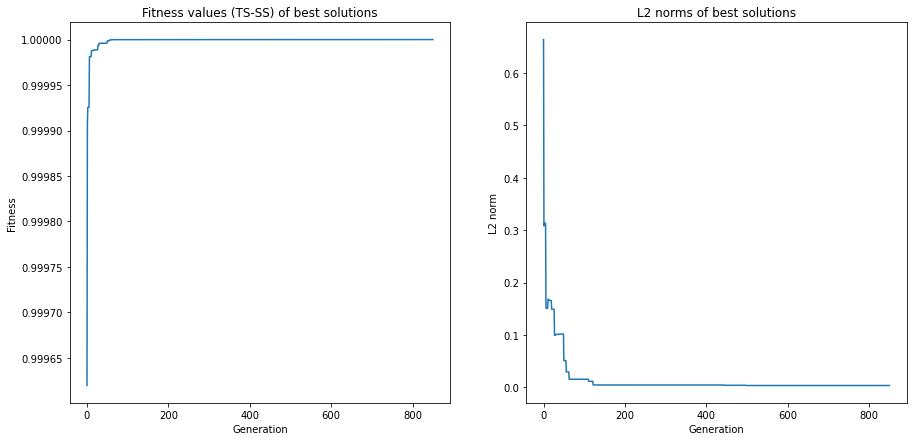

In [229]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

f.patch.set_facecolor('xkcd:white')

best_sols = ga.best_solutions_fitness
ax[0].plot(best_sols)

# fitness_median = np.median(best_sols)
# ax[0].scatter([np.argmin(best_sols), np.argmax(best_sols), best_sols.index(fitness_median)], [np.min(best_sols), np.max(best_sols), fitness_median], c='r', marker='x')
# ax[0].text(np.argmin(best_sols), np.min(best_sols), "Min: {:.4f}".format(np.min(best_sols)))
# ax[0].text(np.argmax(best_sols), np.max(best_sols), "Max: {:.4f}".format(np.max(best_sols)))
# ax[0].text(best_sols.index(fitness_median), fitness_median, "Median: {:.4f}".format(fitness_median))

ax[0].set_xlabel('Generation')
ax[0].set_ylabel('Fitness')
ax[0].set_title('Fitness values (TS-SS) of best solutions')

ax[1].plot(norms)

# norm_median = np.median(norms)
# ax[1].scatter([np.argmin(norms), np.argmax(norms), norms.index(norm_median)], [np.min(norms), np.max(norms), norm_median], c='r', marker='x')
# ax[1].text(np.argmin(norms), np.min(norms), "Min: {:.4f}".format(np.min(norms)))
# ax[1].text(np.argmax(norms), np.max(norms), "Max: {:.4f}".format(np.max(norms)))
# ax[1].text(norms.index(norm_median), norm_median, "Median: {:.4f}".format(norm_median))

ax[1].set_xlabel('Generation')
ax[1].set_ylabel('L2 norm')
ax[1].set_title('L2 norms of best solutions')
plt.show()

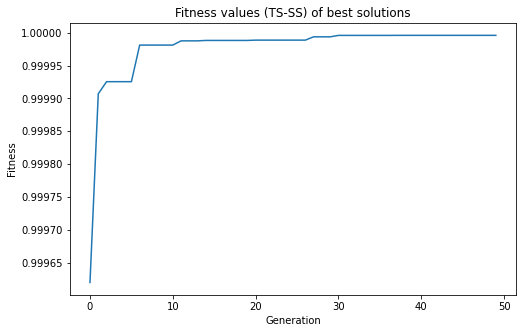

In [225]:
plt.figure(figsize=(8, 5))
plt.plot(ga.best_solutions_fitness[:50])
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness values (TS-SS) of best solutions')
plt.show()

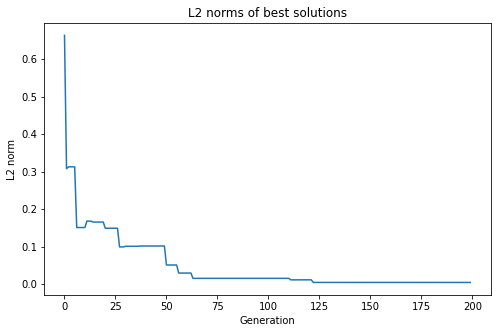

In [226]:
plt.figure(figsize=(8, 5))
plt.plot(norms[:200])
plt.xlabel('Generation')
plt.ylabel('L2 norm')
plt.title('L2 norms of best solutions')
plt.show()

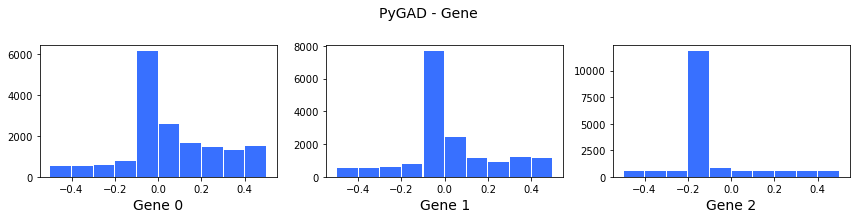

In [227]:
ga.plot_genes(graph_type='histogram')
plt.show()

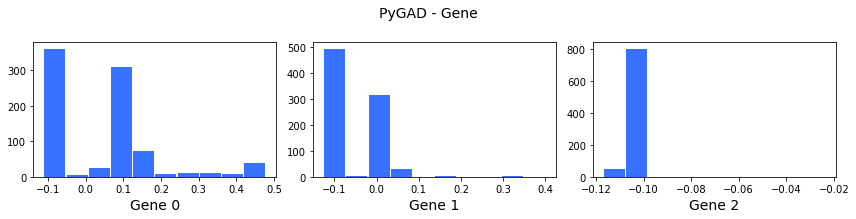

In [228]:
ga.plot_genes(graph_type='histogram', solutions='best')
plt.show()